# Imports

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas
from scattertools.support import molstat
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# always use the same testdata
shutil.copyfile('./bu/H-D_DMPC_D2O_35C_FQ.ABS', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/H-D_DMPC_35D2O_35C_FQ.ABS', os.getcwd()+'/sim1.dat')
shutil.copyfile('./bu/H-D_DMPC_H2O_35C_FQ.ABS', os.getcwd()+'/sim2.dat')

'/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_d54DMPC_ThreeContrasts/sim2.dat'

# Variables for example fit and optimization

In [2]:
# Run Optimization or only example fit and data simulation
RunFit=True
burn=15000
steps=200

store = "T"
setupdir = os.getcwd()
runfile = "sansves"
fitsource = "SASView"

if RunFit:
    # remove store directory if it already exists
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))

# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%write_and_run sansves.py
from bumps.names import *
import bumps.curve
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids

import numpy

# constants
dimension = 100
stepsize = 1.
z = numpy.linspace(0, 99, 100, endpoint=True)

def bilayer(z, bulknsld, l_lipid1, l_lipid2, sigma=3.0, vf_bilayer=1.0, frac_deut=0.9):
    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, startz=20., l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer, nf_lipids=[1-frac_deut, frac_deut])

    # print(z)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', np.arange(dimension) * stepsize)
    problem.results = blm.fnWriteResults2Dict({}, 'bilayer')

    # Return nSLD profile in Refl1D units
    return nsld*1e6

def Dummy(x, l_lipid=11., sigma=3.0, frac_deut=0.9):
    #################################################
    # bilayer update
    sldarr0 = bilayer(z, float(model0.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    sldarr1 = bilayer(z, float(model1.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    sldarr2 = bilayer(z, float(model2.sld_solvent.value), l_lipid, l_lipid, sigma=sigma, frac_deut=frac_deut)
    for i in range(pars0['n']):
        getattr(model0, 'sld'+str(i+1)).value = sldarr0[i]
        getattr(model1, 'sld'+str(i+1)).value = sldarr1[i]
        getattr(model2, 'sld'+str(i+1)).value = sldarr2[i]
        getattr(model0, 'thickness'+str(i+1)).value = 1.
        getattr(model1, 'thickness'+str(i+1)).value = 1.
        getattr(model2, 'thickness'+str(i+1)).value = 1.

    result = numpy.array([1., 2., 3.])
    return result

### Define bilayer object
myristoyl = cmp.Component(name='myristoyl', formula='C13 H27', cell_volume=782./2.0, length=11.0)
dmyristoyl = cmp.Component(name='myristoyl', formula='C13 D27', cell_volume=782./2.0, length=11.0)
DMPC = cmp.Lipid(name='DMPC', headgroup=lipids.PC, tails=2 * [myristoyl], methyls=[cmp.methyl])
dDMPC = cmp.Lipid(name='dDMPC', headgroup=lipids.PC, tails=2 * [dmyristoyl], methyls=[cmp.Dmethyl])
blm = mol.BLM(lipids=[DMPC, dDMPC], lipid_nf=[0.1, 0.9])

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
data1 = load_data('sim1.dat')
data2 = load_data('sim2.dat')

qmin = 0.02
qmax = 0.40
setattr(data0, 'qmin', qmin)
setattr(data0, 'qmax', qmax)
setattr(data1, 'qmin', qmin)
setattr(data1, 'qmax', qmax)
setattr(data2, 'qmin', qmin)
setattr(data2, 'qmax', qmax)

# DEFINE THE MODEL
# copied and initialized the custom model with up to 100 sld and thickness parameters in sasmodels/models
# a second hard-coded limit in sasmodels/modelinfo.py line 594 was manually increased from 20 to 120.
# further in sasmodels/data.py replace all imports from sas.sascalc. ... to from sasdata. ...
kernel = load_model('my_core_multi_shell@hardsphere')

pars0 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=2.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)
pars1 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)
pars2 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.33, n=100, radius_effective=60.0, volfraction=0.01)

model0 = Model(kernel, **pars0)
model1 = Model(kernel, **pars1)
model2 = Model(kernel, **pars2)

# Bilayer specific-parameters are passed into a dummy function
xfoo = numpy.array([1., 2., 3.])
yfoo = numpy.array([1., 2., 3.])
dyfoo = numpy.array([0.01, 0.01, 0.01])
M0 = Curve(Dummy, xfoo, yfoo, dyfoo, l_lipid=11., sigma=3., frac_deut=0.9)
M0.l_lipid.range(8, 12)
M0.sigma.range(2.0, 3.0)
M0.frac_deut.range(0.7, 0.99)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 0.2)
background1 = Parameter(name='background1', value=0.4).range(0.01, 2.0)
background2 = Parameter(name='background2', value=0.4).range(0.01, 2.0)
sld_solvent0 = sld_core0 = Parameter(name='sld_solvent0', value=2.0).range(6.2, 6.4)
sld_solvent1 = sld_core1 = Parameter(name='sld_solvent1', value=2.0).range(1.0, 3.)
sld_solvent2 = sld_core2 = Parameter(name='sld_solvent2', value=2.0).range(-0.56, -0.54)
scale0 = Parameter(name='scale0', value=0.1).range(0.01, 15.0)
scale1 = Parameter(name='scale1', value=0.1).range(0.01, 10.0)
scale2 = Parameter(name='scale2', value=0.1).range(0.01, 10.0)
vf0 = Parameter(name='vf0', value=0.1).range(0.01, 0.1)
#vf1 = Parameter(name='vf1', value=0.1).range(0.01, 0.4)
#vf2 = Parameter(name='vf2', value=0.1).range(0.01, 0.4)
vf1 = vf2 = vf0

#pd0 = Parameter(name='pd0', value=0.1).range(0.01, 0.5)
#pd1 = Parameter(name='pd1', value=0.1).range(0.01, 0.5)
#pd2 = Parameter(name='pd2', value=0.1).range(0.01, 0.5)

model0.scale = scale0
model0.background = background0
model0.sld_solvent = sld_solvent0
model0.sld_core = sld_core0
#model0.radius.range(40., 1200.)
#model0.radius_pd = pd0
model0.radius_effective = model0.radius + 50.
model0.volfraction = vf0

model1.scale = scale1
model1.background = background1
model1.sld_solvent = sld_solvent1
model1.sld_core = sld_core1
#model1.radius = model0.radius
#model1.radius_pd = pd1
model1.radius_effective = model0.radius
model1.volfraction = vf1

model2.scale = scale2
model2.background = background2
model2.sld_solvent = sld_solvent2
model2.sld_core = sld_core2
#model2.radius = model0.radius
#model2.radius_pd = pd2
model2.radius_effective = model0.radius
model2.volfraction = vf2

M1 = Experiment(data=data0, model=model0)
M2 = Experiment(data=data1, model=model1)
M3 = Experiment(data=data2, model=model2)

problem = MultiFitProblem([M0, M1, M2, M3])

2. Run Example Fit

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_d54DMPC_ThreeContrasts/T/sansves.py
No state to reload.
# steps: 200, # draws: 26000
step 1 cost 1235.130(40)
                               frac_deut .....|....   0.860968 in (0.7,0.99)
                                 l_lipid ........|.    11.4144 in (8,12)
                                   sigma .....|....    2.57268 in (2,3)
                             background0 .|........  0.0319299 in (0.01,0.2)
                                  scale0 ...|......    4.59322 in (0.01,15)
                            sld_solvent0 .........|    6.39298 in (6.2,6.4)
                                     vf0 |.........  0.0136461 in (0.01,0.1)
                             background1 ...|......   0.794021 in (0.01,2)
                                  scale1 .|........    1.97394 in (0.01,10)
                            sld_solvent1 .|........    1.22097 in (1,3)
            

Process SpawnPoolWorker-9:
Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/bumps-0.9.0-py3.8.egg/bumps/mapper.py", line 126, in _MP_run_problem
    return MPMapper.problem.nllf(point)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/bumps-0.9.0-py3.8.egg/bumps/fitproblem.py", line 477, in nllf
    pparameter, pconstraints, pmodel = s

-- Model 0 
.frac_deut = 0.914089 in [0.7,0.99]
.l_lipid = 10.8877 in [8,12]
.sigma = 2.40784 in [2,3]

[chisq=0.0(12), nllf=0]
-- Model 1 sim0.dat
.background = background0 = 0.0650699 in [0.01,0.2]
.n = 100
.radius = 500
.radius_effective = (radius + 50.0) = 550
.radius_effective_mode = 1
.radius_pd = 0.33
.radius_pd_n = 35
.radius_pd_nsigma = 3
.scale = scale0 = 12.2521 in [0.01,15]
.sld1 = 6.35482
.sld10 = 6.35481
.sld100 = 6.35482
.sld100_M0 = 0
.sld100_mphi = 0
.sld100_mtheta = 0
.sld10_M0 = 0
.sld10_mphi = 0
.sld10_mtheta = 0
.sld11 = 6.35477
.sld11_M0 = 0
.sld11_mphi = 0
.sld11_mtheta = 0
.sld12 = 6.35458
.sld12_M0 = 0
.sld12_mphi = 0
.sld12_mtheta = 0
.sld13 = 6.35367
.sld13_M0 = 0
.sld13_mphi = 0
.sld13_mtheta = 0
.sld14 = 6.35013
.sld14_M0 = 0
.sld14_mphi = 0
.sld14_mtheta = 0
.sld15 = 6.33842
.sld15_M0 = 0
.sld15_mphi = 0
.sld15_mtheta = 0
.sld16 = 6.30581
.sld16_M0 = 0
.sld16_mphi = 0
.sld16_mtheta = 0
.sld17 = 6.22923
.sld17_M0 = 0
.sld17_mphi = 0
.sld17_mtheta = 0
.sld18

Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 438, in wrapper
    return func(*args, **kw)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 501, in _plot_result1D
    plt.plot(theory_x, theory_scale*mtheory, '-')
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2740, in plot
    return gca().plot(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1662, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y mu

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1            frac_deut  0.873(69)   0.897   0.914 [   0.80    0.93] [   0.72    0.96]
 2              l_lipid  10.34(76)  10.397  10.888 [   9.57   11.10] [   8.92   11.77]
 3                sigma   2.68(30)   2.811   2.408 [   2.29    2.96] [   2.03    2.99]
 4          background0 0.0652(23) 0.06517 0.06507 [ 0.0631  0.0672] [ 0.0608  0.0697]
 5               scale0    6.9(38)    6.70   12.25 [    1.9    11.3] [    1.1    14.2]
 6         sld_solvent0  6.301(65)   6.302   6.355 [   6.22    6.38] [   6.20    6.40]
 7                  vf0  35(19)e-3  0.0294  0.0154 [  0.019   0.053] [  0.015   0.093]
 8          background1 0.6725(62)  0.6729  0.6729 [  0.667   0.679] [  0.657   0.683]
 9               scale1    6.1(20)   6.099   8.367 [   4.04    8.37] [   1.78    9.57]
10         sld_solvent1   1.90(49)   1.842   1.893 [   1.36    2.47] [   1.11    2.83]
11          background2  1.090(11)  1.0907 

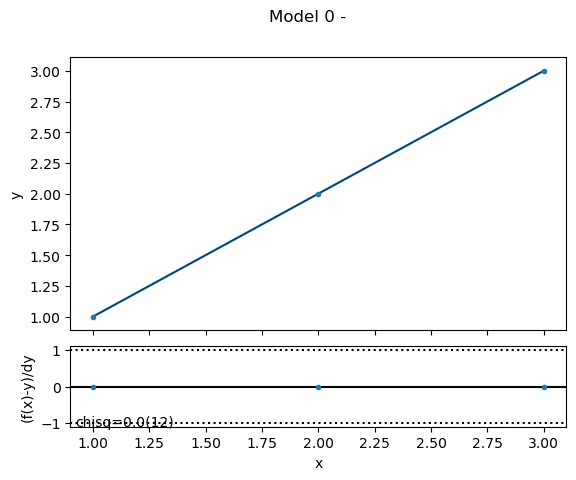

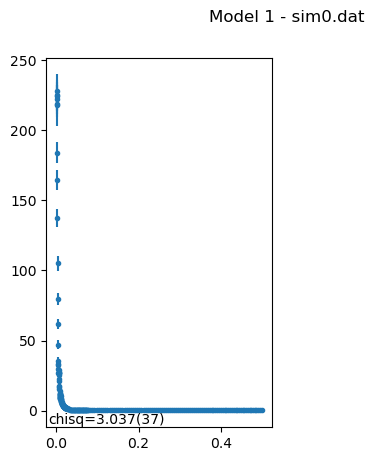

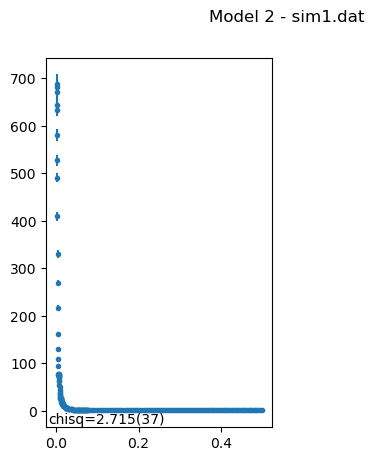

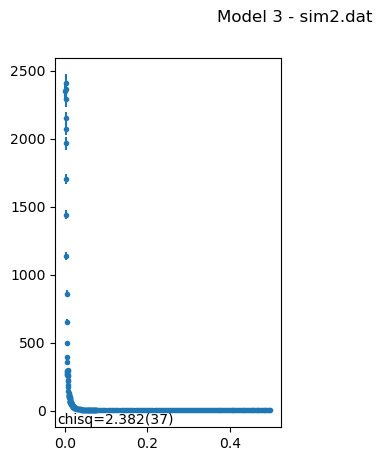

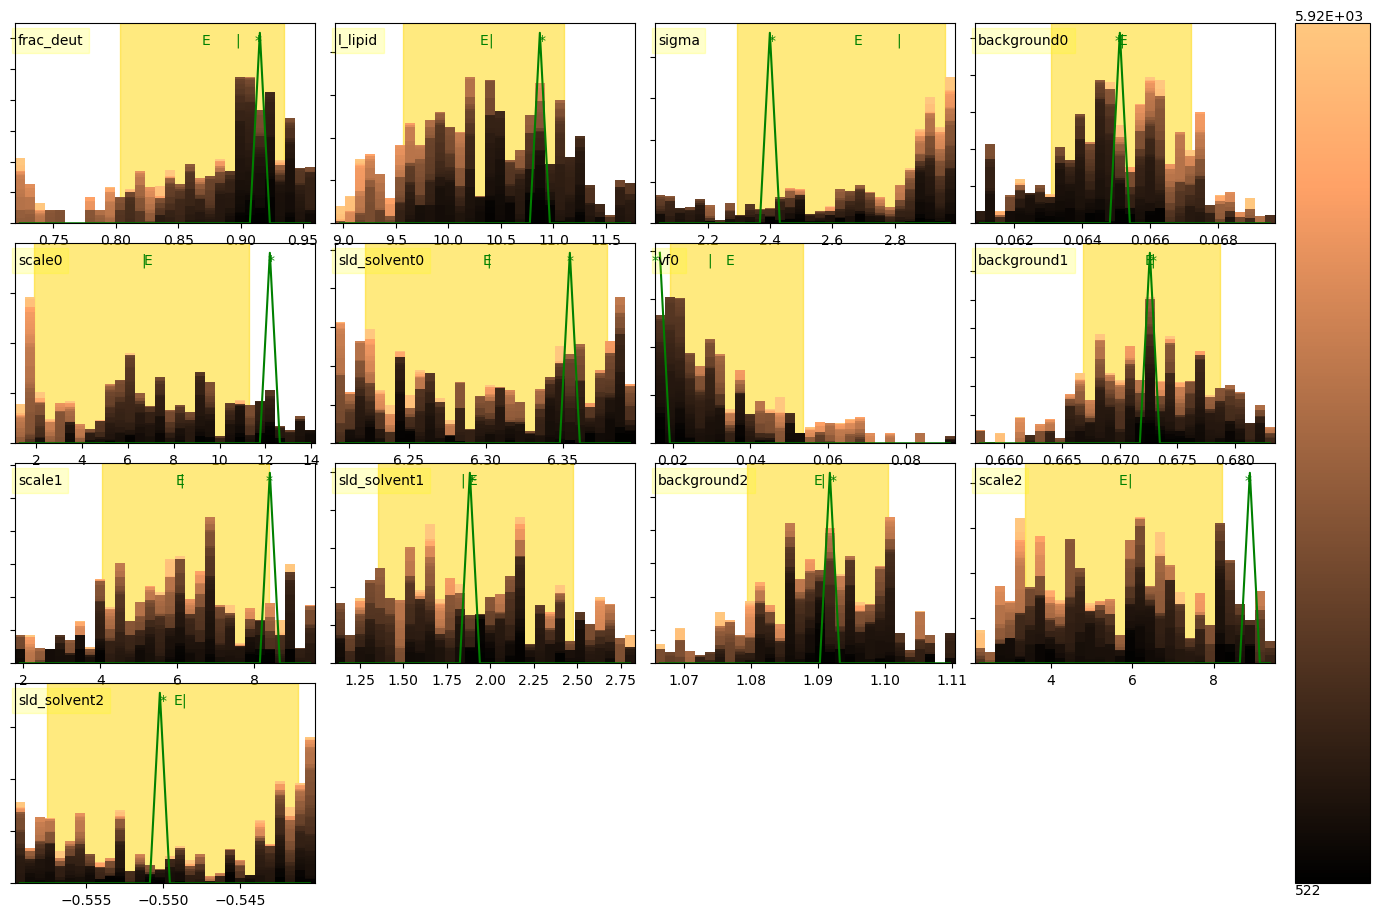

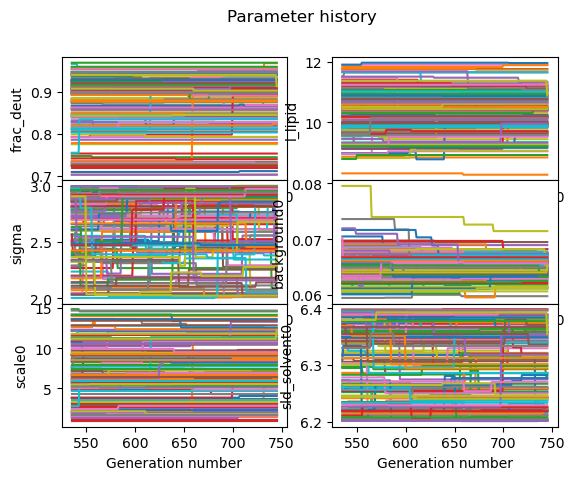

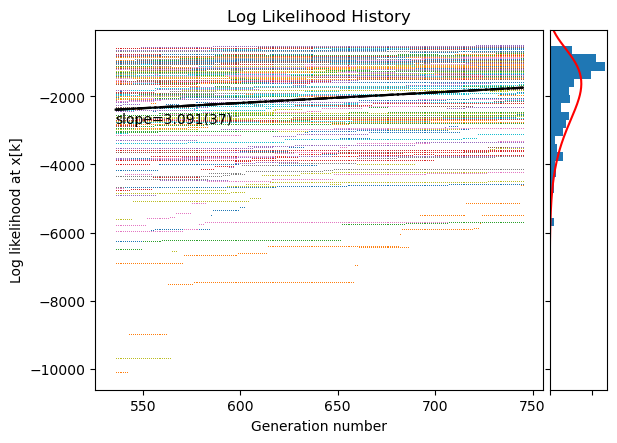

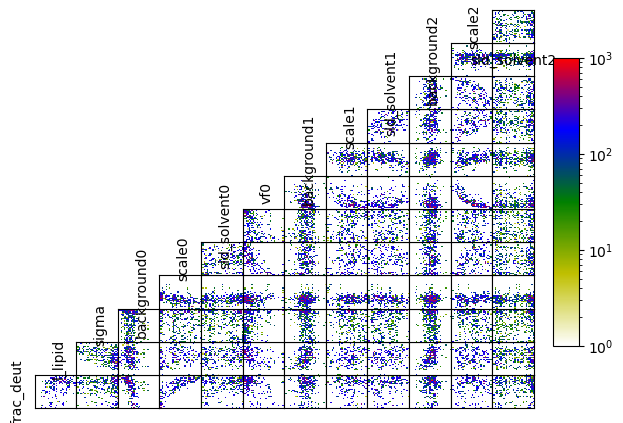

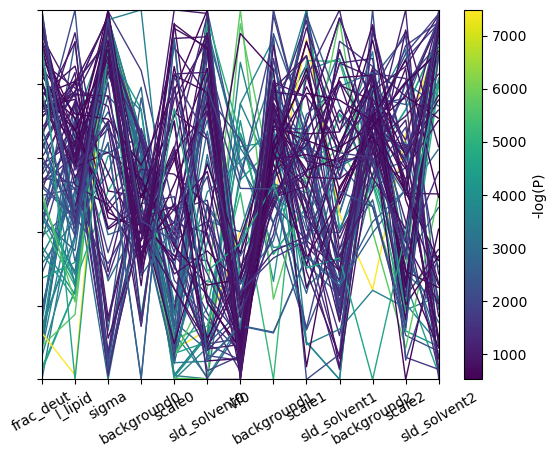

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fitobj.fnRestoreFit()

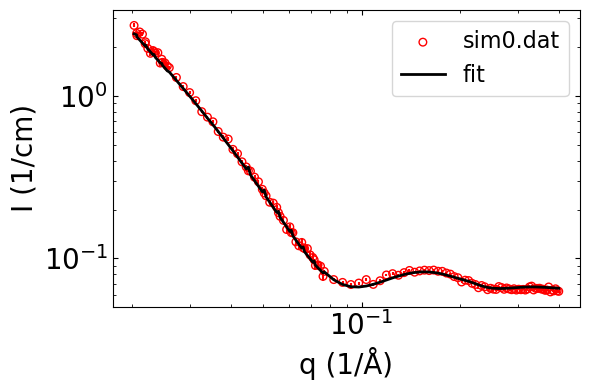

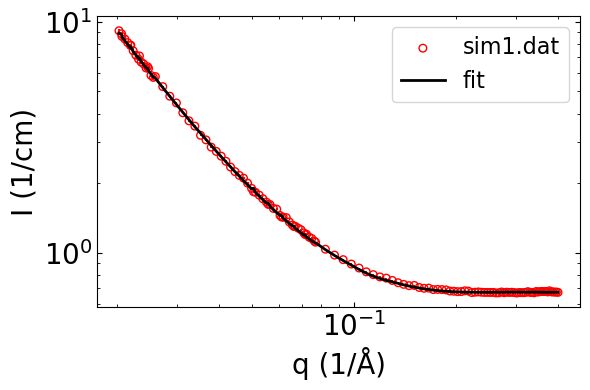

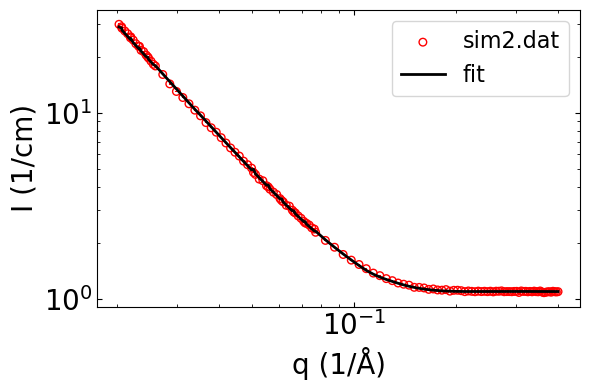

In [5]:
pd = [None, data0.x[(data0.x >= qmin) & (data0.x <= qmax)], data1.x[(data1.x >= qmin) & (data1.x <= qmax)], data2.x[(data2.x >= qmin) & (data2.x <= qmax)]]
pd2 = [None, data0.dx[(data0.x >= qmin) & (data0.x <= qmax)], data1.dx[(data1.x >= qmin) & (data1.x <= qmax)], data2.dx[(data2.x >= qmin) & (data2.x <= qmax)]]
#bg = [None, 0.06548, 0.6729, 1.0937]
bg = [0., 0., 0., 0.]
i=0
for M in fitobj.Interactor.problem.models:
    M.chisq()
    theo = M.fitness.theory()
    if not isinstance(M.fitness, bumps.curve.Curve):
        fig, ax = plt.subplots()
        ax.errorbar(pd[i], M.fitness.Iq-bg[i], yerr=M.fitness.dIq, ls='none', color='r')
        ax.scatter(pd[i], M.fitness.Iq-bg[i], s=30, marker='o', facecolors='none', edgecolors='r', label=M.fitness.name)
        ax.plot(pd[i], theo-bg[i], label="fit", color='black', linewidth=2)
        ax.legend(loc="upper right", fontsize=16)
        plt.xlabel("q (1/Å)", fontsize=20)
        plt.ylabel("I (1/cm)", fontsize=20)
        ax.minorticks_on()
        ax.tick_params(which="both", direction="in", labelsize=20)
        ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax.set_yscale('log')
        ax.set_xscale('log')
        #plt.xlim(0, 100)
        #plt.ylim(1e-3, 100)
        #plt.xticks(numpy.arange(-35, 36, 5.0))
        #plt.grid(True, which='Both')
        fig.patch.set_facecolor('white')
        ax.figure.set_size_inches(6, 4)
        plt.tight_layout()
        plt.savefig(os.path.join(store, "IvsQ"+str(i)), facecolor="white")
        plt.show()
        numpy.savetxt(os.path.join(store, "IvsQ"+str(i)+".dat"), numpy.c_[pd[i], M.fitness.Iq, M.fitness.dIq, pd2[i], theo], delimiter=' ', header="Q Iq dIq dQ fit")
    i+=1



In [6]:
sparse = 0.05
fitobj.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 1417

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,frac_deut,[ | -| ],0.70,0.99,0.798752,0.898366,0.939266,-0.099614,0.040900,0.682689
1,fit,l_lipid,[ | - | ],8.00,12.00,9.561978,10.312850,11.098959,-0.750873,0.786108,0.682689
2,fit,sigma,[ | - |],2.00,3.00,2.338241,2.817426,2.964999,-0.479185,0.147573,0.682689
3,fit,background0,[ + ],0.01,0.20,0.062881,0.065070,0.067077,-0.002189,0.002007,0.682689
4,fit,scale0,[ | - | ],0.01,15.00,1.911588,6.609139,11.270083,-4.697551,4.660945,0.682689
...,...,...,...,...,...,...,...,...,...,...,...
59,bilayer,thickness_inner_leaflet,,NaN,NaN,10.944770,11.804229,12.704019,-0.859459,0.899790,0.682689
60,bilayer,thickness_outer_leaflet,,NaN,NaN,10.944770,11.804229,12.704019,-0.859459,0.899790,0.682689
61,bilayer,water in inner headgroups,,NaN,NaN,0.453771,0.484005,0.513216,-0.030234,0.029211,0.682689
62,bilayer,water in hydrocarbons,,NaN,NaN,0.026926,0.041616,0.055219,-0.014691,0.013603,0.682689


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat. Plot the median bilayer profile

In [7]:
fitobj.fnProfilesStat()
pandas.DataFrame(fitobj.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.defect_hg
1,bilayer.defect_hc
2,bilayer.headgroup1_1
3,bilayer.headgroup1_1.carbonyl_glycerol
4,bilayer.headgroup1_1.choline
5,bilayer.headgroup1_1.phosphate
6,bilayer.headgroup1_2
7,bilayer.headgroup1_2.carbonyl_glycerol
8,bilayer.headgroup1_2.choline
9,bilayer.headgroup1_2.phosphate


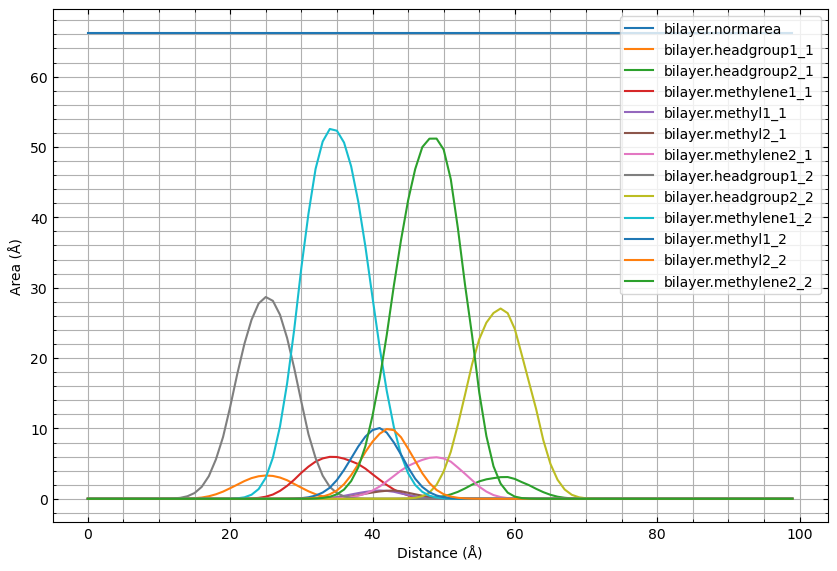

In [10]:
import matplotlib.pyplot as plt

median=['bilayer.normarea', 'bilayer.headgroup1_1', 'bilayer.headgroup2_1', 'bilayer.methylene1_1', 'bilayer.methyl1_1', 'bilayer.methyl2_1', 'bilayer.methylene2_1', 'bilayer.headgroup1_2', 'bilayer.headgroup2_2', 'bilayer.methylene1_2', 'bilayer.methyl1_2', 'bilayer.methyl2_2', 'bilayer.methylene2_2']
uncertainties=[]

fig, ax = plt.subplots()
for gp in median:
    zaxis = fitobj.diStatResults['Molgroups'][gp]['zaxis']
    area = fitobj.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fitobj.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fitobj.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()